# Multi-class classifier: MNIST images

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/parrt/fundamentals-of-deep-learning/blob/main/notebooks/6.multiclass-classifier-mnist.ipynb)

By [Terence Parr](https://explained.ai).

To demonstrate k class classification instead of binary classification, we use the traditional MNIST digital image recognition problem. We'll again use a random forest model as a baseline classifier. Instead of a sigmoid on a single output neuron, k class classifiers use k neurons in the final layer and then a softmax computation instead of a simple sigmoid. We see fairly decent recognition results with just 50 neurons. By using 1000 neurons, we get slightly better results. To demonstrate cyclic learning rates, which sometimes helps to find more general solutions, there's a final model using pytorch's CyclicLR learning rate scheduler.

In [36]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from matplotlib import colors 
import colour

%config InlineBackend.figure_format = 'retina'

import tsensor

In [37]:
def plot_loss(history, ax=None, maxy=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    loss = history[:,0]
    val_loss = history[:,1]
    if maxy:
        ax.set_ylim(0,maxy)
    else:
        ax.set_ylim(0,torch.max(val_loss))
    ax.plot(loss, label='train_loss')
    ax.plot(val_loss, label='val_loss')
    ax.legend(loc='upper right')
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/{os.environ['USER']}/Desktop/{file}.pdf")
        
def plot_accur(history, ax=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Epochs")
    accur = history[:,2]
    val_accur = history[:,3]
    ax.set_ylim(0,1.05)
    ax.plot(accur, label='accur')
    ax.plot(val_accur, label='val_accur')
    ax.legend(loc='lower right')
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/{os.environ['USER']}/Desktop/{file}.pdf")
        
def imgrid(images, digits, dim=(5,5), figsize=(4, 4)):
    fig, axes = plt.subplots(*dim, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        img_as_row = images[i]
        img28x28 = img_as_row.reshape(28,28)
        ax.axis('off') # don't show x, y axes
        ax.imshow(img28x28, cmap='Greys')
        ax.text(0, 8, digits[i], color='#313695', fontsize=15)

## Load data

Let's use a subset of the well-known MNIST handwritten digits data set. This is like the "hello world" of image recognition for deep learning. 

In [38]:
df_mnist = pd.read_csv("https://mlbook.explained.ai/data/mnist-10k-sample.csv.zip")
X = df_mnist.drop('digit', axis=1).values # get just pixels
y = df_mnist['digit'].values              # get just digit value

In [39]:
X.shape

(10000, 784)

In [40]:
# shuffle
n = len(X)
idx = np.random.randint(0,n,n)
X = X[idx,:]
y = y[idx]

In [41]:
X.shape

(10000, 784)

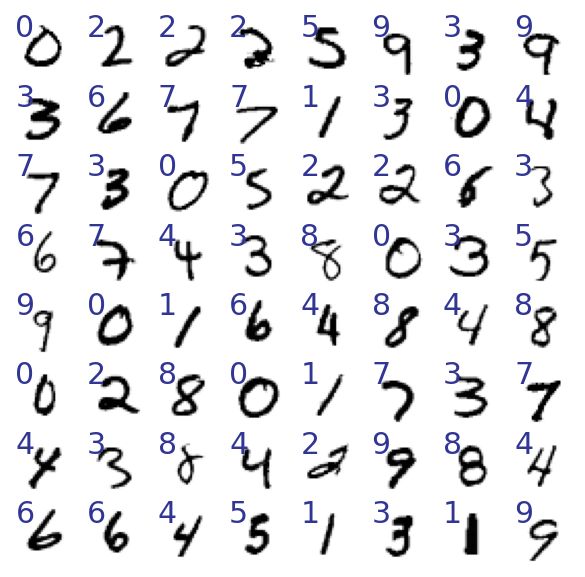

In [42]:
imgrid(X,digits=y,dim=(8,8),figsize=(5,5))

In [43]:
X = torch.tensor(X).float()
y = torch.tensor(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Random forest baseline

In [44]:
cl = RandomForestClassifier(n_estimators=900, n_jobs=-1)
cl.fit(X_train, y_train) 

RandomForestClassifier(n_estimators=900, n_jobs=-1)

In [45]:
y_train_accuracy = cl.score(X_train, y_train)
y_accuracy = cl.score(X_test, y_test)
y_train_accuracy, y_accuracy

(1.0, 0.9765)

## Vanilla one hidden layer of 50 neurons, softmax on end

In [46]:
def ctrain0(model, X, y, learning_rate = .0001, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(nepochs+1):
        y_pred = model(X)
        # Assume model yields softmax probabilities
        loss = F.cross_entropy(y_pred, y)
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:5d} cross entropy loss {loss:7.4f}")

        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"LAST        cross entropy loss {loss:7.4f}")

In [47]:
model = nn.Sequential(
    nn.Linear(784, 50), # 50 neurons
    nn.ReLU(),
    nn.Linear(50, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

In [48]:
ctrain0(model, X_train, y_train, learning_rate = .03, nepochs=1000)

Epoch     0 cross entropy loss  2.3010
Epoch   100 cross entropy loss  1.5718
Epoch   200 cross entropy loss  1.4851
Epoch   300 cross entropy loss  1.4768
Epoch   400 cross entropy loss  1.4747
Epoch   500 cross entropy loss  1.4746
Epoch   600 cross entropy loss  1.4743
Epoch   700 cross entropy loss  1.4741
Epoch   800 cross entropy loss  1.4740
Epoch   900 cross entropy loss  1.4740
Epoch  1000 cross entropy loss  1.4739
LAST        cross entropy loss  1.4739


In [49]:
y_pred = model(X_train)
y_pred = torch.argmax(y_pred, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")

Training accuracy 0.987


In [50]:
conf = confusion_matrix(y_train, y_pred)
print(conf)

[[847   0   0   0   0   0   1   0   1   1]
 [  0 849   4   0   2   1   0   0   0   0]
 [  0   0 784   1   6   0   0   6   2   2]
 [  0   2   1 794   0   3   0   0   4   0]
 [  0   3   0   0 787   0   0   0   0   2]
 [  1   0   0   4   1 712   4   1   3   0]
 [  2   0   0   0   0   2 757   0   1   0]
 [  1   2   3   1   4   0   0 856   2   0]
 [  0   4   1   4   0   0   0   0 795   1]
 [  6   0   0   4   3   0   1   1   5 715]]


In [51]:
y_test_pred = model(X_test)
y_test_pred = torch.argmax(y_test_pred, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Validation accuracy 0.965


In [52]:
confusion_matrix(y_test, y_test_pred)
print(conf)

[[847   0   0   0   0   0   1   0   1   1]
 [  0 849   4   0   2   1   0   0   0   0]
 [  0   0 784   1   6   0   0   6   2   2]
 [  0   2   1 794   0   3   0   0   4   0]
 [  0   3   0   0 787   0   0   0   0   2]
 [  1   0   0   4   1 712   4   1   3   0]
 [  2   0   0   0   0   2 757   0   1   0]
 [  1   2   3   1   4   0   0 856   2   0]
 [  0   4   1   4   0   0   0   0 795   1]
 [  6   0   0   4   3   0   1   1   5 715]]


## Track validation versus training loss

In [53]:
def ctrain1(model, X_train, y_train, X_test, y_test, 
            learning_rate = .0001, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = []
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        # Assume model yields softmax probabilities
        loss = F.cross_entropy(y_pred, y_train)
        y_pred = torch.argmax(y_pred, axis=1)
        ncorrect = torch.sum(y_pred==y_train)
        accur = ncorrect.float() / len(y_train)

        y_test_pred = model(X_test)
        loss_test = F.cross_entropy(y_test_pred, y_test)
        y_test_pred = torch.argmax(y_test_pred, axis=1)
        ncorrect = torch.sum(y_test_pred==y_test)
        loss_accur = ncorrect.float() / len(y_test)
        
        history.append((loss, loss_test, accur, loss_accur))
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} cross entropy loss {loss:7.4f}   test loss {loss_test:7.4f}")

        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"LAST        cross entropy loss {loss:7.4f}")
    return torch.tensor(history)

In [54]:
# make sure to create a new model otherwise it starts from where it left off
model = nn.Sequential(
    nn.Linear(784, 50),
    nn.ReLU(),
    nn.Linear(50, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

In [55]:
history = ctrain1(model, X_train, y_train, X_test, y_test,
                  learning_rate = .03, nepochs=1000)

Epoch    0 cross entropy loss  2.3023   test loss  2.3017
Epoch  100 cross entropy loss  1.4859   test loss  1.5091
Epoch  200 cross entropy loss  1.4815   test loss  1.5049
Epoch  300 cross entropy loss  1.4801   test loss  1.5042
Epoch  400 cross entropy loss  1.4781   test loss  1.5036
Epoch  500 cross entropy loss  1.4776   test loss  1.5045
Epoch  600 cross entropy loss  1.4760   test loss  1.5019
Epoch  700 cross entropy loss  1.4752   test loss  1.5025
Epoch  800 cross entropy loss  1.4751   test loss  1.5027
Epoch  900 cross entropy loss  1.4750   test loss  1.5028
Epoch 1000 cross entropy loss  1.4750   test loss  1.5028
LAST        cross entropy loss  1.4750


In [56]:
y_pred = model(X_train)
y_pred = torch.argmax(y_pred, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")

Training accuracy 0.986


In [57]:
y_test_pred = model(X_test)
y_test_pred = torch.argmax(y_test_pred, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Validation accuracy 0.958


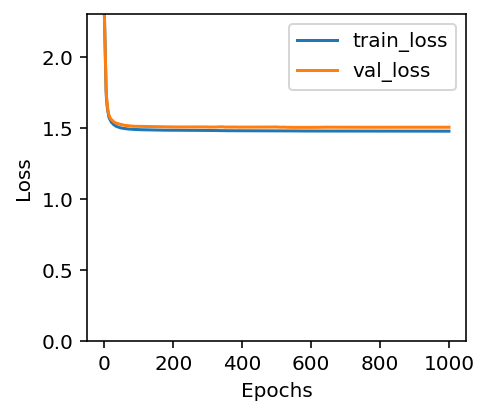

In [58]:
plot_loss(history)

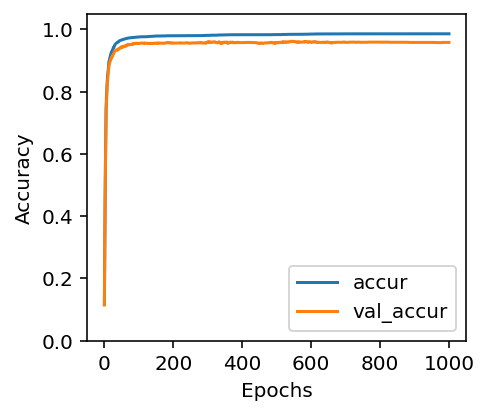

In [59]:
plot_accur(history)

## Use many neurons

In [60]:
# make sure to create a new model otherwise it starts from where it left off
model = nn.Sequential(
    nn.Linear(784, 1000),
    nn.ReLU(),
    nn.Linear(1000, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

In [61]:
history = ctrain1(model, X_train, y_train, X_test, y_test,
                  learning_rate = 0.01, nepochs=1000)

Epoch    0 cross entropy loss  2.3018   test loss  2.3018
Epoch  100 cross entropy loss  1.6410   test loss  1.6521
Epoch  200 cross entropy loss  1.4940   test loss  1.5156
Epoch  300 cross entropy loss  1.4694   test loss  1.4924
Epoch  400 cross entropy loss  1.4686   test loss  1.4906
Epoch  500 cross entropy loss  1.4680   test loss  1.4908
Epoch  600 cross entropy loss  1.4673   test loss  1.4902
Epoch  700 cross entropy loss  1.4672   test loss  1.4894
Epoch  800 cross entropy loss  1.4671   test loss  1.4892
Epoch  900 cross entropy loss  1.4671   test loss  1.4891
Epoch 1000 cross entropy loss  1.4671   test loss  1.4891
LAST        cross entropy loss  1.4671


In [62]:
y_pred = model(X_train)
y_pred = torch.argmax(y_pred, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")

Training accuracy 0.994


In [63]:
y_test_pred = model(X_test)
y_test_pred = torch.argmax(y_test_pred, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Validation accuracy 0.973


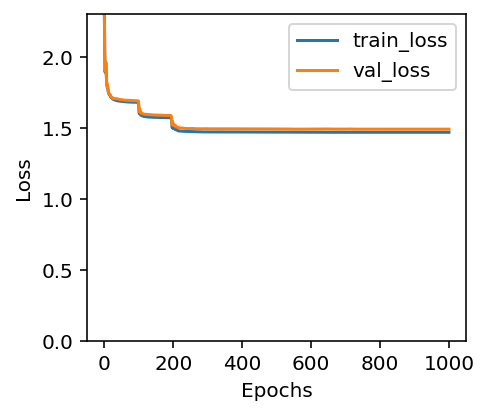

In [64]:
plot_loss(history)

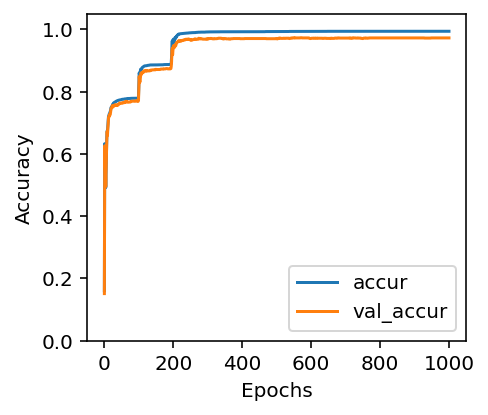

In [65]:
plot_accur(history)

## Cyclic learning rate

In [66]:
def ctrain2(model, X_train, y_train, X_test, y_test, 
            nepochs=2000,
            base_lr=0.01, max_lr=0.05):
    optimizer = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
                                                  mode='triangular2',
                                                  step_size_up=500,
                                                  base_lr=base_lr, max_lr=max_lr,
                                                  cycle_momentum=False)
    history = []
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        # Assume model yields softmax probabilities
        loss = F.cross_entropy(y_pred, y_train)
        y_pred = torch.argmax(y_pred, axis=1)
        ncorrect = torch.sum(y_pred==y_train)
        accur = ncorrect.float() / len(y_train)

        y_test_pred = model(X_test)
        loss_test = F.cross_entropy(y_test_pred, y_test)
        y_test_pred = torch.argmax(y_test_pred, axis=1)
        ncorrect = torch.sum(y_test_pred==y_test)
        loss_accur = ncorrect.float() / len(y_test)
        
        history.append((loss, loss_test, accur, loss_accur))
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} cross entropy loss {loss:7.4f}   test loss {loss_test:7.4f}   LR {scheduler.get_last_lr()[0]:7.6f}")

        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
        scheduler.step()
        
    print(f"LAST        cross entropy loss {loss:7.4f}")
    return torch.tensor(history)

In [67]:
# make sure to create a new model otherwise it starts from where it left off
model = nn.Sequential(
    nn.Linear(784, 1000),
    nn.ReLU(),
    nn.Linear(1000, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

In [68]:
history = ctrain2(model, X_train, y_train, X_test, y_test,
                  base_lr=0.005, max_lr=0.03, nepochs=1000)

Epoch    0 cross entropy loss  2.3036   test loss  2.3036   LR 0.005000
Epoch  100 cross entropy loss  1.4827   test loss  1.5032   LR 0.010000
Epoch  200 cross entropy loss  1.4735   test loss  1.4948   LR 0.015000
Epoch  300 cross entropy loss  1.4700   test loss  1.4937   LR 0.020000
Epoch  400 cross entropy loss  1.4691   test loss  1.4910   LR 0.025000
Epoch  500 cross entropy loss  1.4690   test loss  1.4909   LR 0.030000
Epoch  600 cross entropy loss  1.4683   test loss  1.4905   LR 0.025000
Epoch  700 cross entropy loss  1.4681   test loss  1.4909   LR 0.020000
Epoch  800 cross entropy loss  1.4681   test loss  1.4908   LR 0.015000
Epoch  900 cross entropy loss  1.4680   test loss  1.4912   LR 0.010000
Epoch 1000 cross entropy loss  1.4680   test loss  1.4906   LR 0.005000
LAST        cross entropy loss  1.4680


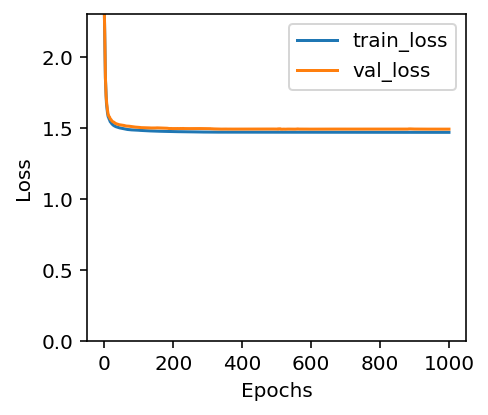

In [69]:
plot_loss(history)

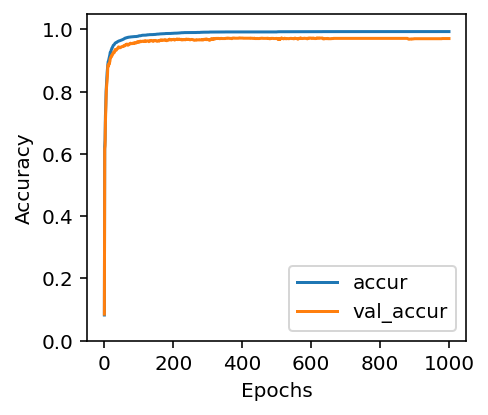

In [70]:
plot_accur(history)